# Lets implement Boosting classifiers on cancer dataset
Lets explore
1. GBDT
2. ADAboost
3. XGboost 
4. LightGBM
5. Cat Boost


Import Section 


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import operator
import copy
import json
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
from xgboost import XGBClassifier
# https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
from lightgbm import LGBMClassifier
# https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
# https://catboost.ai/en/docs/concepts/python-quickstart
!pip install catboost
from catboost import CatBoostClassifier, Pool
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


Lets work on the cancer dataset

In [5]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir cancerdataset
!kaggle datasets download -d amandam1/breastcancerdataset
!unzip breastcancerdataset.zip -d cancerdataset

Saving kaggle.json to kaggle.json
  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 7.29MB/s]
Archive:  breastcancerdataset.zip
  inflating: cancerdataset/BRCA.csv  


Lets Load the dataset

In [6]:
cancerdata = pd.read_csv('/content/cancerdataset/BRCA.csv')
cancerdata.head()

,Patient_ID,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,TCGA-D8-A1XD,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,15-Jan-17,19-Jun-17,Alive
1,TCGA-EW-A1OX,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,26-Apr-17,09-Nov-18,Dead
2,TCGA-A8-A079,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,08-Sep-17,09-Jun-18,Alive
3,TCGA-D8-A1XR,56.0,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,25-Jan-17,12-Jul-17,Alive
4,TCGA-BH-A0BF,56.0,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,06-May-17,27-Jun-19,Dead


Lets do some preprocessing

In [7]:
# drop duplicates
print("data before duplicate removal : ",cancerdata.shape[0])
cancerdata = cancerdata.drop_duplicates()
print("data after duplicate remomval : ",cancerdata.shape[0])


data before duplicate removal :  341
data after duplicate remomval :  335


In [8]:
# lets only take few features which are important
cancerdata = cancerdata.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,15]]
cancerdata.head()


,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Patient_Status
0,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,Alive
1,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,Dead
2,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Alive
3,56.0,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,Alive
4,56.0,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Dead


In [9]:
# null value analysis
print(cancerdata.isnull().sum())
print("data before null remomval : ",cancerdata.shape[0])
cancerdata = cancerdata.dropna()
print("data after null remomval : ",cancerdata.shape[0])
    

Age                1
Gender             1
Protein1           1
Protein2           1
Protein3           1
Protein4           1
Tumour_Stage       1
Histology          1
ER status          1
PR status          1
HER2 status        1
Surgery_type       1
Patient_Status    14
dtype: int64
data before null remomval :  335
data after null remomval :  321


In [10]:
# lets encode the categorical features
X = cancerdata.iloc[:,:-1]
y = cancerdata.iloc[:,-1]


In [11]:
y.value_counts()

Alive    255
Dead      66
Name: Patient_Status, dtype: int64

In [12]:
features_with_noencoding = X.iloc[:,[0,2,3,4,5]]
feature_with_ordinal_encoding = X.iloc[:,[6]]
feature_with_one_hot_encoding = X.iloc[:,[1,7,8,9,10,11]]
feature_with_ordinal_encoding.Tumour_Stage = feature_with_ordinal_encoding.Tumour_Stage.map({'I':1,"II":2,"III":3})

In [13]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
feature_with_one_hot_encoding = enc.fit_transform(feature_with_one_hot_encoding).toarray()
feature_with_one_hot_encoding = pd.DataFrame(feature_with_one_hot_encoding,columns = enc.get_feature_names_out())
feature_with_one_hot_encoding


,Gender_FEMALE,Gender_MALE,Histology_Infiltrating Ductal Carcinoma,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,ER status_Positive,PR status_Positive,HER2 status_Negative,HER2 status_Positive,Surgery_type_Lumpectomy,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
317,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
318,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
319,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [14]:
feature_with_one_hot_encoding.shape

(321, 13)

In [15]:
X = pd.concat([features_with_noencoding.reset_index(drop = True), feature_with_ordinal_encoding.reset_index(drop = True),feature_with_one_hot_encoding.reset_index(drop = True)], axis=1)
X.shape
y = y.map({"Alive":0,"Dead":1}).reset_index(drop=True)

In [16]:
X

,Age,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Gender_FEMALE,Gender_MALE,Histology_Infiltrating Ductal Carcinoma,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,ER status_Positive,PR status_Positive,HER2 status_Negative,HER2 status_Positive,Surgery_type_Lumpectomy,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy
0,36.0,0.080353,0.42638,0.54715,0.273680,3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,43.0,-0.420320,0.57807,0.61447,-0.031505,2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,69.0,0.213980,1.31140,-0.32747,-0.234260,3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,56.0,0.345090,-0.21147,-0.19304,0.124270,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,56.0,0.221550,1.90680,0.52045,-0.311990,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,36.0,0.231800,0.61804,-0.55779,-0.517350,3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
317,44.0,0.732720,1.11170,-0.26952,-0.354920,2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
318,61.0,-0.719470,2.54850,-0.15024,0.339680,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
319,79.0,0.479400,2.05590,-0.53136,-0.188480,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [17]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42, n_jobs = -1)
X, y = smt.fit_resample(X, y)

In [18]:
y.value_counts()


0    248
1    248
Name: Patient_Status, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [20]:
result_dataset = pd.DataFrame(data =np.zeros((4,7)) , index = ['accuracy_score','f1_score','roc_auc_score','log_loss'],columns = ['GBDT','ADAboost_LR','ADAboost_SVC','ADAboost_DT','XGboost','LightGBM','Cat_Boost'])
result_dataset

,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def metrics(classfier,X_test,y_test,name):
  y_pred = classfier.predict(X_test)
  y_prob = classfier.predict_proba(X_test)[:,[1]]
  accuracy = accuracy_score(y_test,y_pred)
  rocauc = roc_auc_score(y_test,y_prob)
  logloss = log_loss(y_test,y_prob)
  f1score = f1_score(y_test,y_pred)
  result_dataset[name]['accuracy_score'] = accuracy
  result_dataset[name]['f1_score'] = f1score
  result_dataset[name]['roc_auc_score'] = rocauc
  result_dataset[name]['log_loss'] = logloss
  print("accuracy score :",accuracy)
  print("f1 score :",f1score)
  print("auc score :",rocauc)
  print("log loss :",logloss)
  print('classification report : \n', classification_report(y_test,y_pred))
  print('*********** confusion matrx ***********')
  sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues')
  plt.show()

# lets start with GBDT

In [22]:
gbdt_clf = GradientBoostingClassifier(random_state = 42)
param_grids = {'loss' : ['log_loss', 'deviance', 'exponential'],'learning_rate' : [0.1,0.3,0.6,0.9],'n_estimators':[80,90,100,110],'criterion':['friedman_mse','squared_error','mse']}
gbdt_clf = GridSearchCV(estimator = gbdt_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
gbdt_clf.fit(X_train,y_train)
gbdt_clf.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=80; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=80; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=80; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=80; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=80; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=90; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=90; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=90; total time=   0.0s
[CV] END criterion=friedman_mse, learning_rate=0.1, loss=log_loss, n_estimators=90; total time=   0.0s
[CV] END c

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.6,
                           random_state=42)

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.6,random_state=42)

accuracy score : 0.7919463087248322
f1 score : 0.8074534161490683
auc score : 0.8655797101449275
log loss : 0.7324853401485774
classification report : 
               precision    recall  f1-score   support

           0       0.78      0.77      0.77        69
           1       0.80      0.81      0.81        80

    accuracy                           0.79       149
   macro avg       0.79      0.79      0.79       149
weighted avg       0.79      0.79      0.79       149

*********** confusion matrx ***********


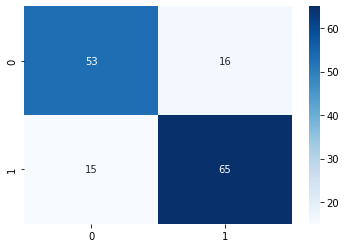

********* dataset *********


,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.791946,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.807453,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.865580,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.732485,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
gbdt_clf = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.6,random_state=42)
gbdt_clf.fit(X_train,y_train)
metrics(gbdt_clf,X_test,y_test,name='GBDT')
print('********* dataset *********')
result_dataset

# lets implement ADAboost with logistic regression as base model


In [28]:
basemodel = LogisticRegression(random_state = 42)
adalogis_clf = AdaBoostClassifier(base_estimator = basemodel,random_state = 42)
param_grids = {'base_estimator__C': [0.0001, 0.01, 1.0, 10.0,100.0, 1000.0],'learning_rate' : [1.0,3.0,5.0,7.0],'n_estimators':[80,90,100,110],'algorithm':['SAMME','SAMME.R']}
adalogis_clf = GridSearchCV(estimator = adalogis_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
adalogis_clf.fit(X_train,y_train)
adalogis_clf.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=80; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=80; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=80; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=80; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=80; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=90; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=90; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimators=90; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.0001, learning_rate=1.0, n_estimato

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=LogisticRegression(random_state=42),
                   n_estimators=80, random_state=42)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=LogisticRegression(random_state=42),
                   n_estimators=10, random_state=42)

accuracy score : 0.5637583892617449
f1 score : 0.5962732919254657
auc score : 0.6144021739130434
log loss : 0.667543903470019
classification report : 
               precision    recall  f1-score   support

           0       0.53      0.52      0.53        69
           1       0.59      0.60      0.60        80

    accuracy                           0.56       149
   macro avg       0.56      0.56      0.56       149
weighted avg       0.56      0.56      0.56       149

*********** confusion matrx ***********


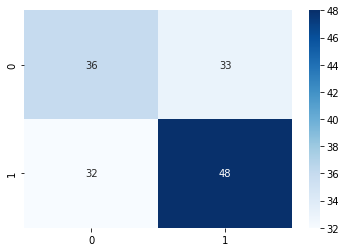

********* dataset *********


,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.791946,0.563758,0.0,0.0,0.0,0.0,0.0
f1_score,0.807453,0.596273,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.865580,0.614402,0.0,0.0,0.0,0.0,0.0
log_loss,0.732485,0.667544,0.0,0.0,0.0,0.0,0.0


In [29]:
basemodel = LogisticRegression(random_state = 42)
adalogis_clf = AdaBoostClassifier(algorithm='SAMME', base_estimator=basemodel,random_state = 42, n_estimators=10)
adalogis_clf.fit(X_train,y_train)
metrics(adalogis_clf,X_test,y_test,name='ADAboost_LR')
print('********* dataset *********')
result_dataset

# lets implement ADAboost with SVC as base model


In [30]:
basemodel = SVC(random_state = 42)
adasvc_clf = AdaBoostClassifier(base_estimator = basemodel,random_state = 42)
param_grids = {'base_estimator__C': [0.001, 0.01, 1.0, 10.0],'base_estimator__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],'learning_rate' : [0.01,0.1,1.0,3.0],'n_estimators':[5,10,20,30,35],'algorithm':['SAMME','SAMME.R']}
adasvc_clf = GridSearchCV(estimator = adasvc_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
adasvc_clf.fit(X_train,y_train)
adasvc_clf.best_estimator_

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
[CV] END algorithm=SAMME, base_estimator__C=0.001, base_estimator__kernel=linear, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.001, base_estimator__kernel=linear, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.001, base_estimator__kernel=linear, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.001, base_estimator__kernel=linear, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.001, base_estimator__kernel=linear, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__C=0.001, base_estimator__kernel=linear, learning_rate=0.01, n_estimators=10; total time=   0.1s
[CV] END algorithm=SAMME, base_estimator__C=0.001, base_estimator__kernel=linear, learning_rate=0.01, n_estimator

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=SVC(C=10.0, kernel='linear', random_state=42),
                   learning_rate=0.01, n_estimators=10, random_state=42)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=SVC(C=10.0, kernel='linear', random_state=42),
                   learning_rate=0.01, n_estimators=10, random_state=42)

accuracy score : 0.5973154362416108
f1 score : 0.625
auc score : 0.5986413043478261
log loss : 0.7149839992448028
classification report : 
               precision    recall  f1-score   support

           0       0.57      0.57      0.57        69
           1       0.62      0.62      0.62        80

    accuracy                           0.60       149
   macro avg       0.60      0.60      0.60       149
weighted avg       0.60      0.60      0.60       149

*********** confusion matrx ***********


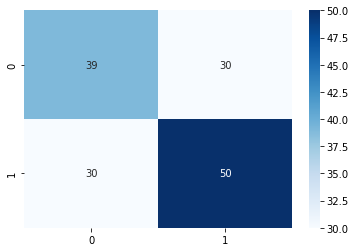

********* dataset *********


,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.791946,0.563758,0.597315,0.0,0.0,0.0,0.0
f1_score,0.807453,0.596273,0.625000,0.0,0.0,0.0,0.0
roc_auc_score,0.865580,0.614402,0.598641,0.0,0.0,0.0,0.0
log_loss,0.732485,0.667544,0.714984,0.0,0.0,0.0,0.0


In [31]:
adasvc_clf = AdaBoostClassifier(algorithm='SAMME', base_estimator=SVC(C=10.0, kernel='linear', random_state=42), learning_rate=0.01, n_estimators=10, random_state=42)
adasvc_clf.fit(X_train,y_train)
metrics(adasvc_clf,X_test,y_test,name='ADAboost_SVC')
print('********* dataset *********')
result_dataset

# lets implement ADAboost with Decision tree as base model


In [32]:
basemodel = DecisionTreeClassifier(random_state = 42)
adadt_clf = AdaBoostClassifier(base_estimator = basemodel,random_state = 42)
param_grids = {'base_estimator__criterion': ['gini','entropy'],'base_estimator__max_depth' : [5,6,7,8,9],'learning_rate' : [0.01,0.1,1.0,3.0],'n_estimators':[5,10,20,30,35],'algorithm':['SAMME','SAMME.R']}
adadt_clf = GridSearchCV(estimator = adadt_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
adadt_clf.fit(X_train,y_train)
adadt_clf.best_estimator_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END algorithm=SAMME, base_estimator__criterion=gini, base_estimator__max_depth=5, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__criterion=gini, base_estimator__max_depth=5, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__criterion=gini, base_estimator__max_depth=5, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__criterion=gini, base_estimator__max_depth=5, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__criterion=gini, base_estimator__max_depth=5, learning_rate=0.01, n_estimators=5; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__criterion=gini, base_estimator__max_depth=5, learning_rate=0.01, n_estimators=10; total time=   0.0s
[CV] END algorithm=SAMME, base_estimator__criterion=gini, base_estimator__max_depth

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=8,
                                                         random_state=42),
                   n_estimators=30, random_state=42)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=8,
                                                         random_state=42),
                   n_estimators=30, random_state=42)

accuracy score : 0.87248322147651
f1 score : 0.888888888888889
auc score : 0.956159420289855
log loss : 0.7929338685537466
classification report : 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85        69
           1       0.84      0.95      0.89        80

    accuracy                           0.87       149
   macro avg       0.88      0.87      0.87       149
weighted avg       0.88      0.87      0.87       149

*********** confusion matrx ***********


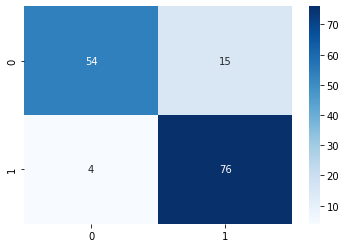

********* dataset *********


,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.791946,0.563758,0.597315,0.872483,0.0,0.0,0.0
f1_score,0.807453,0.596273,0.625000,0.888889,0.0,0.0,0.0
roc_auc_score,0.865580,0.614402,0.598641,0.956159,0.0,0.0,0.0
log_loss,0.732485,0.667544,0.714984,0.792934,0.0,0.0,0.0


In [33]:
adadt_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42), n_estimators=30, random_state=42)
adadt_clf.fit(X_train,y_train)
metrics(adadt_clf,X_test,y_test,name='ADAboost_DT')
print('********* dataset *********')
result_dataset

# lets implement XGBoost 

In [34]:
xgboost_clf = XGBClassifier(random_state = 42)
#param_grids = {'max_depth' : [1,2,3,4,5,6,7],'learning_rate' : [0.01,0.1,1.0,3.0],'n_estimators':[5,10,20,30,35],'subsample': [0.5,0.6,0.7,0.8],'colsample_bytree': [0.5,0.6,0.7,0.8] ,'reg_alpha':[0.1,0.3,0.5,0.7,0.9],'reg_lambda':[0.1,0.3,0.5,0.7,0.9]}
param_grids = {'max_depth' : [1,2,3,4],'learning_rate' : [0.1,1.0,0.01],'n_estimators':[36,34,35],'subsample': [0.8,0.6],'colsample_bytree': [0.3,0.4,0.5] ,'reg_alpha':[0.7,0.6],'reg_lambda':[0.1,0.0,0.2]}
xgboost_clf = GridSearchCV(estimator = xgboost_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
xgboost_clf.fit(X_train,y_train)
xgboost_clf.best_estimator_

Streaming output truncated to the last 5000 lines.
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimat

XGBClassifier(colsample_bytree=0.4, max_depth=4, n_estimators=36,
              random_state=42, reg_alpha=0.7, reg_lambda=0.0, subsample=0.6)

XGBClassifier(colsample_bytree=0.4, max_depth=4, n_estimators=36,
              random_state=42, reg_alpha=0.7, reg_lambda=0.0, subsample=0.6)

accuracy score : 0.7919463087248322
f1 score : 0.7973856209150326
auc score : 0.8710144927536232
log loss : 0.46470442504290765
classification report : 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79        69
           1       0.84      0.76      0.80        80

    accuracy                           0.79       149
   macro avg       0.79      0.79      0.79       149
weighted avg       0.80      0.79      0.79       149

*********** confusion matrx ***********


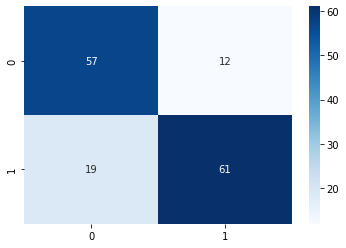

********* dataset *********


,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.791946,0.563758,0.597315,0.872483,0.791946,0.0,0.0
f1_score,0.807453,0.596273,0.625000,0.888889,0.797386,0.0,0.0
roc_auc_score,0.865580,0.614402,0.598641,0.956159,0.871014,0.0,0.0
log_loss,0.732485,0.667544,0.714984,0.792934,0.464704,0.0,0.0


In [35]:
xgboost_clf = XGBClassifier(colsample_bytree=0.4, max_depth=4, n_estimators=36, random_state=42, reg_alpha=0.7, reg_lambda=0.0, subsample=0.6)
xgboost_clf.fit(X_train,y_train)
metrics(xgboost_clf,X_test,y_test,name='XGboost')
print('********* dataset *********')
result_dataset

# lets implement Lgboost

In [36]:
lgbm_clf = LGBMClassifier(random_state = 42)
param_grids = {'boosting_type':['gbdt','dart','goss','rf'],'max_depth' : [1,2,3,4],'learning_rate' : [0.1,1.0,0.01],'n_estimators':[36,34,35],'subsample': [0.8,0.6],'colsample_bytree': [0.3,0.4,0.5] ,'reg_alpha':[0.7,0.6],'reg_lambda':[0.1,0.0,0.2]}
lgbm_clf = GridSearchCV(estimator = lgbm_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
lgbm_clf.fit(X_train,y_train)
lgbm_clf.best_estimator_

Streaming output truncated to the last 5000 lines.
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0,

LGBMClassifier(boosting_type='dart', colsample_bytree=0.3, learning_rate=1.0,
               max_depth=4, n_estimators=36, random_state=42, reg_alpha=0.7,
               subsample=0.8)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.3, learning_rate=1.0,
               max_depth=4, n_estimators=36, random_state=42, reg_alpha=0.7,
               subsample=0.8)

accuracy score : 0.825503355704698
f1 score : 0.8333333333333334
auc score : 0.8608695652173913
log loss : 0.4606918936990047
classification report : 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82        69
           1       0.86      0.81      0.83        80

    accuracy                           0.83       149
   macro avg       0.82      0.83      0.83       149
weighted avg       0.83      0.83      0.83       149

*********** confusion matrx ***********


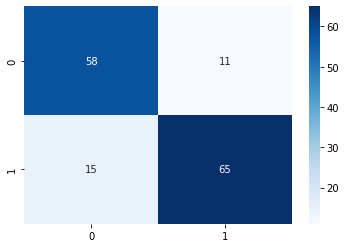

********* dataset *********


,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.791946,0.563758,0.597315,0.872483,0.791946,0.825503,0.0
f1_score,0.807453,0.596273,0.625000,0.888889,0.797386,0.833333,0.0
roc_auc_score,0.865580,0.614402,0.598641,0.956159,0.871014,0.860870,0.0
log_loss,0.732485,0.667544,0.714984,0.792934,0.464704,0.460692,0.0


In [37]:
lgbm_clf = LGBMClassifier(boosting_type='dart', colsample_bytree=0.3, learning_rate=1.0,max_depth=4, n_estimators=35, random_state=42, reg_alpha=0.9,subsample=0.9)
lgbm_clf.fit(X_train,y_train)
metrics(lgbm_clf,X_test,y_test,name='LightGBM')
print('********* dataset *********')
result_dataset

# lets implement CATBOOST

In [38]:
catboost_clf = CatBoostClassifier(random_state = 42)
param_grids = {'max_depth' : [1,2,3,4],'learning_rate' : [0.1,1.0,0.01],'n_estimators':[36,34,35],'subsample': [0.8,0.6],'colsample_bylevel': [0.3,0.4,0.5] ,'reg_lambda':[0.1,0.0,0.2]}
catboost_clf = GridSearchCV(estimator = catboost_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
catboost_clf.fit(X_train,y_train)
catboost_clf.best_estimator_

Streaming output truncated to the last 5000 lines.
21:	learn: 0.6635737	total: 15.1ms	remaining: 8.26ms
22:	learn: 0.6628536	total: 15.8ms	remaining: 7.57ms
23:	learn: 0.6617165	total: 16.5ms	remaining: 6.87ms
24:	learn: 0.6604769	total: 17.1ms	remaining: 6.16ms
25:	learn: 0.6595005	total: 17.7ms	remaining: 5.45ms
26:	learn: 0.6586469	total: 18.4ms	remaining: 4.77ms
27:	learn: 0.6569882	total: 19.1ms	remaining: 4.09ms
28:	learn: 0.6561025	total: 19.8ms	remaining: 3.41ms
29:	learn: 0.6550839	total: 20.4ms	remaining: 2.72ms
30:	learn: 0.6543951	total: 21.2ms	remaining: 2.05ms
31:	learn: 0.6537451	total: 21.9ms	remaining: 1.37ms
32:	learn: 0.6528659	total: 22.5ms	remaining: 682us
33:	learn: 0.6512828	total: 23.1ms	remaining: 0us
[CV] END colsample_bylevel=0.5, learning_rate=0.01, max_depth=3, n_estimators=34, reg_lambda=0.0, subsample=0.8; total time=   0.1s
0:	learn: 0.6914213	total: 382us	remaining: 12.6ms
1:	learn: 0.6898709	total: 1.24ms	remaining: 19.8ms
2:	learn: 0.6888397	total: 1.

In [39]:
catboost_clf.best_params_

{'colsample_bylevel': 0.4,
 'learning_rate': 1.0,
 'max_depth': 4,
 'n_estimators': 36,
 'reg_lambda': 0.2,
 'subsample': 0.8}

CatBoostClassifier('colsample_bylevel'= 0.4,'learning_rate'= 1.0,'max_depth'= 4,'n_estimators'= 36,'reg_lambda'= 0.2,'subsample'= 0.8)

accuracy score : 0.7919463087248322
f1 score : 0.7973856209150326
auc score : 0.8813405797101448
log loss : 0.4760388765966905
classification report : 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79        69
           1       0.84      0.76      0.80        80

    accuracy                           0.79       149
   macro avg       0.79      0.79      0.79       149
weighted avg       0.80      0.79      0.79       149

*********** confusion matrx ***********


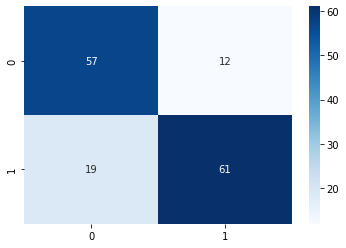

********* dataset *********


,GBDT,ADAboost_LR,ADAboost_SVC,ADAboost_DT,XGboost,LightGBM,Cat_Boost
accuracy_score,0.791946,0.563758,0.597315,0.872483,0.791946,0.825503,0.791946
f1_score,0.807453,0.596273,0.625000,0.888889,0.797386,0.833333,0.797386
roc_auc_score,0.865580,0.614402,0.598641,0.956159,0.871014,0.860870,0.881341
log_loss,0.732485,0.667544,0.714984,0.792934,0.464704,0.460692,0.476039


In [40]:
catboost_clf = CatBoostClassifier(colsample_bylevel= 0.4,learning_rate= 1.0,max_depth= 4,n_estimators= 36,reg_lambda= 0.2,subsample= 0.8,random_state = 42,verbose = 0)
catboost_clf.fit(X_train,y_train)
metrics(catboost_clf,X_test,y_test,name='Cat_Boost')
print('********* dataset *********')
result_dataset